In [1]:
# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
from astropy.coordinates import search_around_sky   # functional interface
import healpy as hp

# Local
import util
import utils


In [2]:
size_ratio = 1
sub_width, sub_height = size_ratio*10/3, size_ratio*2.8
SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 11

rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = SMALL_SIZE
rc_default['axes.labelsize'] = MEDIUM_SIZE
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = MEDIUM_SIZE
rc_default['xtick.labelsize'] = SMALL_SIZE
rc_default['ytick.labelsize'] = SMALL_SIZE
rc_default['legend.fontsize'] = SMALL_SIZE
rc_default['figure.titlesize'] = BIGGER_SIZE
rc_default['lines.linewidth'] = 1
rc_default['lines.markersize'] = 4
rc_default['figure.figsize'] = (sub_width, sub_height)
rc_default['savefig.dpi'] = 300

# Latex related
rc_default['text.usetex'] = True
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)
plt.style.use('tableau-colorblind10')

In [ ]:
def mask_radius_for_mag(mag):
    """
    returns a masking radius in degrees for a star of the given magnitude.
    Used for Tycho-2 and Gaia stars.
    This is in degrees, and is from Rongpu in the thread [decam-chatter 12099].

    Parameters
    ----------
    mag : float
        The magnitude of the star.
    Returns
    -------
    float
        The masking radius in degrees.
    """
    return 1630./3600. * 1.396**(-mag)

def mask_radius_DR9(G):
    """
    Legacy Surveys DR9 bright-star mask radius (arcsec) vs Gaia G.
    Parameters
    ----------
    G : float
        The Gaia G magnitude of the star.
    Returns
    -------
    float
        The masking radius in degrees.
    """

    return(0.5 * mask_radius_for_mag(G))



In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [8]:
Legacy_path = "/its/home/bb345/5-4most_data/CRS/target_catalogues/BG/full_legacy_no_colour_sel/.archive/reduced/desi_bg_nomaskbit_mask_4M_reduced_columns.fits"

In [27]:
Gaia_path = "/its/home/bb345/5-4most_data/other_data/gaia_sources/gaia-mask-dr10_bg_foot.fits"

In [28]:
BG = Table.read(Legacy_path)

In [29]:
gaia = Table.read(Gaia_path)

In [12]:
BG

OBJID,RA,DEC,EBV,WISEMASK_W1,MASKBITS,isBG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_g,mag_i,mag_w1,isBG_4M_v2,desi_bgs_selection,galactic_cap,dr1_bg_mask
,deg,deg,,,,,,,,,,,,,,,
int32,float64,float64,float32,uint8,int32,bool,bool,bool,float32,float32,float32,float32,float32,bool,bool,bytes3,bool
419,157.0072201498557,-2.1468467554514508,0.044455066,0,0,False,False,True,19.254793,18.32375,20.694925,18.70724,17.812822,False,False,NGC,True
645,157.01433423838904,-2.2641702674806825,0.041389566,0,0,False,False,True,18.899773,18.50198,19.443045,18.654955,18.839195,False,True,NGC,True
838,157.0200785116195,-2.3639337222354797,0.039800275,0,0,False,False,True,18.914272,18.500732,19.573341,18.65716,19.303652,False,True,NGC,True
1164,157.02686834051426,-2.159646811120505,0.043790996,0,0,True,False,True,18.984041,18.54076,19.72362,18.707792,18.666428,False,True,NGC,True
1219,157.0281576193182,-2.272059179114334,0.041178815,0,0,True,False,True,18.530964,17.854332,19.707085,18.141018,17.93635,True,True,NGC,True
1576,157.03549970264152,-2.270895163249637,0.041185517,0,0,True,False,True,18.15484,17.266401,19.582981,17.617146,16.646183,True,True,NGC,True
1690,157.03851793006055,-2.226166286097986,0.042040892,0,0,False,False,True,19.321472,18.318218,21.130793,18.684061,17.62561,False,False,NGC,True
1940,157.04382620147746,-2.1518624340791046,0.04378916,0,0,False,False,True,19.178022,18.516327,20.12455,18.78125,18.564873,False,True,NGC,True


In [13]:
gaia.columns

<TableColumns names=('RA','DEC','G','R_medium_arcsec','R_bright_arcsec','isbright','ismedium')>

In [14]:
gaia

RA,DEC,G,R_medium_arcsec,R_bright_arcsec,isbright,ismedium
float64,float64,float32,float32,float32,bool,bool
138.47911287888343,-20.05919361740083,10.202366,0.015056047,0.0075280233,True,True
138.50734940934274,-20.077408392419393,12.119091,0.007943382,0.003971691,True,True
138.532221107817,-20.07108382266964,13.9100685,0.004370377,0.0021851885,False,True
138.46927494528694,-20.0420453591923,14.232986,0.003924034,0.001962017,False,True
138.52447175685128,-20.05602394858007,14.820012,0.003226126,0.001613063,False,True
138.4937099006615,-20.02696478594428,15.237008,0.0028071438,0.0014035719,False,True
138.54332171457176,-20.074527914937907,15.251176,0.0027939072,0.0013969536,False,True
138.5082098091799,-20.032117303717225,15.289503,0.0027584108,0.0013792054,False,True
138.49617838172657,-20.05819089144308,15.302459,0.0027465143,0.0013732571,False,True


In [31]:
BG = BG[(BG['isBG_4M_v2'] == True) & (BG['in_S8'] == True)]
# BG.keep_columns(['RA', 'DEC', 'in_S8', 'MASKBITS', 'isBG_4M_v2'])


In [32]:
BG = BG.to_pandas()


In [39]:
bg = BG

In [33]:
gaia = gaia.to_pandas()

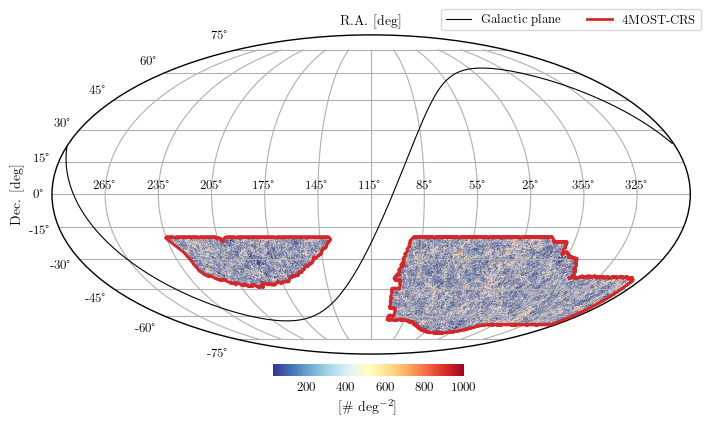

In [34]:
hpmap = utils.create_hp_map(BG['RA'], BG['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

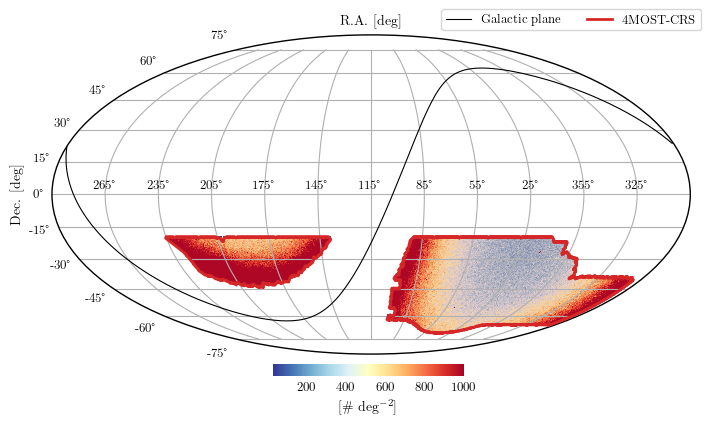

In [35]:
hpmap = utils.create_hp_map(gaia['RA'], gaia['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=1000, fourmost_footprint=True)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord

def mask_radius_for_mag(mag):
    return (1630.0/3600.0) * (1.396)**(-mag)  # degrees

def r_bs_from_mag(mag, factor=0.5):
    return factor * mask_radius_for_mag(mag)  # tweak factor to your exact MASKBIT-1

def _get_col(df, names):
    """Find a column in df by case-insensitive match to any of 'names'."""
    ln = [n.lower() for n in names]
    for c in df.columns:
        if c.lower() in ln:
            return c
    raise KeyError(f"None of {names} found in columns: {list(df.columns)}")

def mean_surface_density_deg2(bg_df, nside=1024):
    """Very simple nbar from convex hull area if healpy not available."""
    try:
        import healpy as hp
        theta = np.deg2rad(90.0 - bg_df[_get_col(bg_df, ['DEC'])].to_numpy())
        phi   = np.deg2rad(bg_df[_get_col(bg_df, ['RA'])].to_numpy())
        pix   = hp.ang2pix(nside, theta, phi, nest=False)
        area_deg2 = np.unique(pix).size * hp.nside2pixarea(nside, degrees=True)
    except Exception:
        # Fallback: spherical convex hull (coarse). Prefer healpy if you have it.
        from scipy.spatial import ConvexHull
        ra = np.deg2rad(bg_df[_get_col(bg_df, ['RA'])].to_numpy())
        dec = np.deg2rad(bg_df[_get_col(bg_df, ['DEC'])].to_numpy())
        # project to unit sphere Cartesian
        x = np.cos(dec)*np.cos(ra); y = np.cos(dec)*np.sin(ra); z = np.sin(dec)
        pts = np.vstack([x,y,z]).T
        hull = ConvexHull(pts)
        area_sr = hull.area  # on unit sphere
        area_deg2 = area_sr * (180/np.pi)**2
    nbar = len(bg_df) / area_deg2
    return nbar, area_deg2

def stacked_overdensity_map(
    gaia_df, bg_df, mag_min, mag_max,
    max_norm=4.0, bins=180, apply_star_mask="none",
    nbar_deg2=None, max_stars=None, verbose=True
):
    # --- resolve columns case-insensitively ---
    g_ra_c  = _get_col(gaia_df, ['RA'])
    g_dec_c = _get_col(gaia_df, ['DEC'])
    g_mag_c = _get_col(gaia_df, ['G','phot_g_mean_mag','g','gmag','G'])

    b_ra_c  = _get_col(bg_df, ['RA'])
    b_dec_c = _get_col(bg_df, ['DEC'])

    # --- select stars in the bin (then optionally downsample) ---
    sel = (gaia_df[g_mag_c] >= mag_min) & (gaia_df[g_mag_c] < mag_max)
    stars = gaia_df.loc[sel, [g_ra_c, g_dec_c, g_mag_c]].copy().reset_index(drop=True)
    if stars.empty:
        raise ValueError(f"No Gaia stars in {mag_min}–{mag_max}.")
    if max_stars is not None and len(stars) > max_stars:
        stars = stars.sample(max_stars, random_state=42).reset_index(drop=True)

    # --- build arrays ONCE and in this order ---
    star_ra  = stars[g_ra_c].to_numpy()
    star_dec = stars[g_dec_c].to_numpy()
    star_mag = stars[g_mag_c].to_numpy()
    R_MS_all = mask_radius_for_mag(star_mag)            # deg
    R_BS_all = r_bs_from_mag(star_mag)                  # deg

    bg_ra  = bg_df[b_ra_c].to_numpy()
    bg_dec = bg_df[b_dec_c].to_numpy()

    # --- SkyCoord built from THESE arrays ---
    star_sc = SkyCoord(star_ra*u.deg, star_dec*u.deg)
    bg_sc   = SkyCoord(bg_ra*u.deg,   bg_dec*u.deg)

    # --- neighbour search (indices into star_sc and bg_sc) ---
    sepmax = (R_BS_all.max() * max_norm) * u.deg
    idx_star, idx_bg, sep2d, _ = star_sc.search_around_sky(bg_sc, sepmax)

    if len(idx_star) == 0:
        raise ValueError("No BG–star pairs within search radius.")

    # Safety assertions: these catch the bug you saw
    assert idx_star.max() < len(star_sc), "idx_star out of range — check you didn't swap inputs."
    assert idx_bg.max()   < len(bg_sc),   "idx_bg out of range — something is inconsistent."

    # --- optional masking at the PAIR level ---
    R_BS_pairs = R_BS_all[idx_star]
    R_MS_pairs = R_MS_all[idx_star]
    sep_deg    = sep2d.to(u.deg).value

    if apply_star_mask == "R_BS":
        keep = sep_deg > R_BS_pairs
    elif apply_star_mask == "R_MS":
        keep = sep_deg > R_MS_pairs
    else:
        keep = np.ones(len(idx_star), dtype=bool)

    if not np.any(keep):
        raise ValueError("All pairs removed by masking.")

    idx_star = idx_star[keep]
    idx_bg   = idx_bg[keep]
    R_BS_pairs = R_BS_pairs[keep]

    # --- compute offsets using a local tangent plane at each star ---
    # This is robust and avoids manual cos(dec) & RA wrapping.
    frames = star_sc[idx_star].skyoffset_frame()
    bg_off = bg_sc[idx_bg].transform_to(frames)
    dlon = bg_off.lon.to(u.deg).value   # small-angle longitude
    dlat = bg_off.lat.to(u.deg).value   # small-angle latitude

    # --- normalise by R_BS and weight by 1/R_BS^2 ---
    x = dlon / R_BS_pairs
    y = dlat / R_BS_pairs
    box = (np.abs(x) <= max_norm) & (np.abs(y) <= max_norm)
    x, y, R_BS_pairs = x[box], y[box], R_BS_pairs[box]
    weights = 1.0 / (R_BS_pairs**2)     # ensures density has units deg^-2

    # --- 2D histogram of proper surface density (deg^-2) ---
    H, xedges, yedges = np.histogram2d(
        x, y, bins=bins, range=[[-max_norm, max_norm], [-max_norm, max_norm]],
        weights=weights
    )
    du = xedges[1] - xedges[0]
    dv = yedges[1] - yedges[0]
    H_density = H / (du * dv)  # deg^-2

    # --- mean density of BG catalogue ---
    if nbar_deg2 is None:
        nbar_deg2, area = mean_surface_density_deg2(bg_df)
    eps = 1e-12
    H_ratio = H_density / (nbar_deg2 + eps)
    H_log2  = np.log2(H_ratio + eps)

    stats = {
        "n_stars": len(stars),
        "n_pairs": len(x),
        "median_RMS_over_RBS": np.median(R_MS_all / R_BS_all),
        "mag_bin": (mag_min, mag_max),
        "nbar_deg2": nbar_deg2
    }
    return {
        "H_log2": H_log2, "H_ratio": H_ratio, "H_density": H_density,
        "xedges": xedges, "yedges": yedges, "extent": [-max_norm, max_norm, -max_norm, max_norm],
        "stats": stats
    }


In [42]:
# ---------- Convenience plotting ----------
def plot_panel(ax, result, title, rms_over_rbs=2.0, vlim=4.0):
    im = ax.imshow(
        result["H_log2"].T,  # transpose to make y up
        origin="lower",
        extent=result["extent"],
        vmin=-vlim, vmax=+vlim,
        cmap="RdBu_r",
        interpolation="nearest"
    )
    ax.set_xlabel(r"$\Delta {\rm RA}/R_{\rm BS}$")
    ax.set_ylabel(r"$\Delta {\rm DEC}/R_{\rm BS}$")
    ax.set_title(title)
    # circles: R_BS (black radius=1), R_MS (red, median scale)
    from matplotlib.patches import Circle
    ax.add_patch(Circle((0,0), 1.0, fill=False, lw=2.0, color="k", alpha=0.8))
    ax.add_patch(Circle((0,0), rms_over_rbs, fill=False, lw=2.0, color="r", alpha=0.8))
    ax.axhline(0, ls="--", lw=0.8, color="k", alpha=0.5)
    ax.axvline(0, ls="--", lw=0.8, color="k", alpha=0.5)
    return im


In [43]:

# ---------- Run for your four bins and two masking choices ----------
mag_bins = [(7,11), (11,12), (12,13), (13,16)]
mask_mode = "none"  # change to "R_BS" or "R_MS" to see masking impact

results = []
for (lo, hi) in mag_bins:
    res = stacked_overdensity_map(
        gaia, bg, lo, hi,
        max_norm=4.0, bins=180,
        apply_star_mask=mask_mode,
        max_stars=None,         # or e.g. 30000 if you need speed
        verbose=True
    )
    results.append(res)

# Plot as a 2x2 panel like your example
fig, axes = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True, sharex=True, sharey=True)
cax = None
for ax, res, (lo, hi) in zip(axes, results, mag_bins):
    im = plot_panel(
        ax, res,
        title=f"{lo:.2f} < G < {hi:.2f}",
        rms_over_rbs=res["stats"]["median_RMS_over_RBS"],
        vlim=4.0
    )
    cax = im  # keep last to colourbar

fig.colorbar(cax, ax=axes, fraction=0.046, pad=0.02, label=r"$\log_{2}\!\left(n/\bar n\right)$")
plt.show()


AssertionError: idx_star out of range — check you didn't swap inputs.